# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from collections import defaultdict
from tqdm import tqdm
import json

In [2]:
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow import keras
from tensorflow.keras import layers

# Load Data

In [3]:
# import pandas as pd

# df = pd.read_csv('../../dataset/weighted_score_above_08.csv')

# df.head()

In [4]:
with open('../combined_df.json', 'r') as f:
    sample_data = [json.loads(line) for line in f]

In [5]:
# Extract valid appids from the sample file
# valid_appids = {entry['appid'] for entry in sample_data}

# Filter df based on appids in the sample
# df = df[df['appid'].isin(valid_appids)]

# Continue processing
# df_games = df[['appid', 'game']]
# df_games = df_games.drop_duplicates(subset='appid')

# appid2game = df_games.set_index('appid')['game'].to_dict()
# game2appid = df_games.set_index('game')['appid'].to_dict()

# del df_games

# df = df[['appid', 'author_steamid', 'voted_up']]
# df.rename(columns={'appid': 'item_id', 'author_steamid': 'user_id', 'voted_up': 'rating'}, inplace=True)

In [6]:
item_id_to_genres = {entry['appid']: entry['genre'] for entry in sample_data}

In [7]:
# df.reset_index(drop=True, inplace=True)

In [8]:
# N_DISPLAY = 30
# has_no_genre_count = 0
# for i, item_id in enumerate(df['item_id'].unique()):
#     genres = item_id_to_genres.get(item_id, [])
#     if not genres:
#         has_no_genre_count += 1
#         continue
# print(f"Number of games without genres: {has_no_genre_count}")

In [9]:
# nan_count = df['rating'].isna().sum()
# print(f"Number of NaN values in 'rating': {nan_count}")

In [10]:
sample_data[0]

{'appid': 550, 'game': 'Left 4 Dead 2', 'genre': ['Action']}

In [11]:
# Create a DataFrame from sample_data
games_data_clean = pd.DataFrame(sample_data)

# Rename columns for clarity
games_data_clean.rename(columns={'game': 'title'}, inplace=True)

# Convert the 'genre' list into a pipe-separated string
games_data_clean['genre'] = games_data_clean['genre'].apply(lambda x: '|'.join(x) if isinstance(x, list) else '')

# Select only the required columns
games_data_clean = games_data_clean[['appid', 'title', 'genre']]
games_data_clean.rename(columns={'appid': 'gameId'}, inplace=True)
games_data_clean.rename(columns={'genre': 'genres'}, inplace=True)

games_data_clean.head()

,gameId,title,genres
0,550,Left 4 Dead 2,Action
1,644560,Mirror,Adventure|Indie|RPG
2,264710,Subnautica,Adventure|Indie
3,294100,RimWorld,Indie|Simulation|Strategy
4,413150,Stardew Valley,Indie|RPG|Simulation


### Create Item Train Feature Vectors

In [12]:
game_features_data = games_data_clean.copy()

In [13]:
game_features_data.head()

,gameId,title,genres
0,550,Left 4 Dead 2,Action
1,644560,Mirror,Adventure|Indie|RPG
2,264710,Subnautica,Adventure|Indie
3,294100,RimWorld,Indie|Simulation|Strategy
4,413150,Stardew Valley,Indie|RPG|Simulation


In [14]:
genre_dummies = game_features_data['genres'].str.get_dummies(sep='|')
genre_counts = genre_dummies.sum()
valid_genres = genre_counts[genre_counts >= 50].index
genre_dummies = genre_dummies[valid_genres]

In [15]:
item_genre_dummies = genre_dummies.add_prefix('item_')

In [16]:
item_features = pd.concat([
    # game_features_data[['gameId']],
    item_genre_dummies
], axis=1)

In [17]:
item_features.head()

,item_Action,item_Adventure,item_Animation & Modeling,item_Audio Production,item_Casual,item_Design & Illustration,item_Early Access,item_Education,item_Family Sharing,item_Free To Play,...,item_Racing,item_Simulation,item_Single-player,item_Software Training,item_Sports,item_Strategy,item_Utilities,item_Video Production,item_Violent,item_Web Publishing
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [18]:
item_features.shape

(27315, 26)

#### Train an autoencoder

In [19]:
item_continuous = []
item_genres = [c for c in item_features.columns if c not in []]

In [20]:
standardizer = StandardScaler()

In [21]:
# item_features[item_continuous] = standardizer.fit_transform(item_features[item_continuous])b

In [22]:
X_item = item_features[item_continuous + item_genres].to_numpy().astype(float)

In [23]:
X_item.shape

(27315, 26)

In [24]:
X_item

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(27315, 26))

In [25]:
input_dim = X_item.shape[1]

In [ ]:
# Define the VAE architecture
from tensorflow.keras.regularizers import l2

latent_dim = 32  # Increased latent dimension to capture more complex patterns

# Encoder
inp = keras.Input(shape=(input_dim,), name='genre_input')
x = layers.Dense(256, activation='relu')(inp)  # Increased neurons
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)

# Latent space
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])

# Decoder
decoder_input = keras.Input(shape=(latent_dim,), name='decoder_input')
x = layers.Dense(64, activation='relu')(decoder_input)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
out = layers.Dense(input_dim, activation='sigmoid')(x)



In [56]:
# from tensorflow.keras.regularizers import l2

# inp = keras.Input(shape=(input_dim,), name='genre_input')
# x = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01))(inp)
# # x = layers.Dropout(0.3)(x)
# x = layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
# latent = layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01), name='item_embedding')(x)
# x = layers.Dense(32, activation='relu', kernel_regularizer=l2(0.01))(latent)
# x = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
# out = layers.Dense(input_dim, kernel_regularizer=l2(0.01))(x)

In [57]:

# Define the encoder, decoder, and VAE models
encoder = keras.Model(inputs=inp, outputs=[z_mean, z_log_var, z], name='vae_encoder')
decoder = keras.Model(inputs=decoder_input, outputs=out, name='vae_decoder')
vae_output = decoder(z)

# Add KL divergence as a custom layer
class KLDivergenceLayer(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        self.add_loss(tf.reduce_mean(kl_loss))  # Add KL divergence to the model's loss
        return inputs

# Apply the KL divergence layer
z_mean, z_log_var = KLDivergenceLayer()([z_mean, z_log_var])

# Define the VAE model
vae = keras.Model(inputs=inp, outputs=vae_output, name='vae')

# Compile the VAE with reconstruction loss
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy')

# Train the VA

In [58]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_autoencoder.h5', monitor='val_loss', save_best_only=True)

# Train the autoencoder with callbacks
# Train the VAE
history = vae.fit(
    X_item, X_item,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=2,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30


1537/1537 - 2s - 2ms/step - loss: 0.0656 - val_loss: 0.1223
Epoch 2/30
1537/1537 - 1s - 938us/step - loss: 0.0196 - val_loss: 0.1394
Epoch 3/30
1537/1537 - 1s - 910us/step - loss: 0.0146 - val_loss: 0.1746
Epoch 4/30
1537/1537 - 1s - 905us/step - loss: 0.0124 - val_loss: 0.1734
Epoch 5/30
1537/1537 - 1s - 904us/step - loss: 0.0112 - val_loss: 0.2472
Epoch 6/30
1537/1537 - 1s - 906us/step - loss: 0.0102 - val_loss: 0.2645
Epoch 7/30
1537/1537 - 1s - 917us/step - loss: 0.0096 - val_loss: 0.2732
Epoch 8/30
1537/1537 - 1s - 905us/step - loss: 0.0091 - val_loss: 0.2620
Epoch 9/30
1537/1537 - 1s - 929us/step - loss: 0.0086 - val_loss: 0.3272
Epoch 10/30
1537/1537 - 1s - 906us/step - loss: 0.0081 - val_loss: 0.2562
Epoch 11/30
1537/1537 - 1s - 901us/step - loss: 0.0079 - val_loss: 0.2659
Epoch 12/30
1537/1537 - 1s - 912us/step - loss: 0.0077 - val_loss: 0.3132
Epoch 13/30
1537/1537 - 1s - 928us/step - loss: 0.0070 - val_loss: 0.3052
Epoch 14/30
1537/1537 - 1s - 915us/step - loss: 0.0068 - val

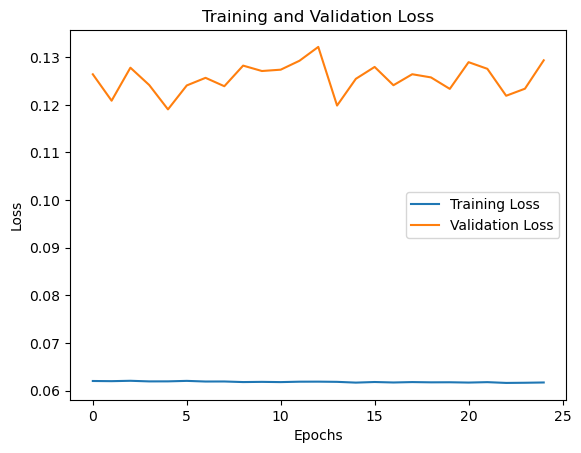

In [ ]:
# Extract loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Selected Movies:
   movieId          title               genres
0      550  Left 4 Dead 2               Action
1   644560         Mirror  Adventure|Indie|RPG
2   264710     Subnautica      Adventure|Indie

Movie Indices for Selected Movies: [np.int64(0), np.int64(1), np.int64(2)]

Top K Recommendations:
   movieId             title           genres  similarity_score
0   780500         Suzy Cube  Adventure|Indie            0.6881
1  1229020    Kona II: Brume  Adventure|Indie            0.6881
2   402260       Dead Secret  Adventure|Indie            0.6881
3  1328840      Lost in Play  Adventure|Indie            0.6881
4   220740  Chaos on Deponia  Adventure|Indie            0.6881


In [ ]:
item_embeddings = encoder.predict(X_item, batch_size=256)  # shape (n_items,32)

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step


In [467]:
embedding_norms = np.linalg.norm(item_embeddings, axis=1, keepdims=True)
embeddings_normalized = item_embeddings / embedding_norms

In [ ]:
# Step 1: Select the first 3 games
selected_games = game_features_data.iloc[:7]
print("Selected Games:")
print(selected_games[['gameId', 'title', 'genres']])

# Step 2: Get game_indices for the selected games
game_indices = []
for game_id in selected_games['gameId']:
    game_indices.append(
        game_features_data.index[game_features_data.gameId == game_id][0]
    )

print("\nGame Indices for Selected Games:", game_indices)

# Step 3: Define the function to get recommendations
def recommend_similar_games(game_indices, embeddings_normalized, games_data_clean, K=5):
    profile = embeddings_normalized[game_indices].mean(axis=0)
    similarity_scores = embeddings_normalized.dot(profile)
    
    # Exclude input games from recommendations
    for ind in game_indices:
        similarity_scores[ind] = -1.0
    
    # Get top-K recommendations
    top_k = np.argsort(similarity_scores)[-K:][::-1]
    recommended_game_ids = game_features_data.iloc[top_k]['gameId']
    recommended_similarity_scores = similarity_scores[top_k]
    
    recommended_df = pd.DataFrame({
        'gameId': recommended_game_ids,
        'similarity_score': np.round(recommended_similarity_scores, 4)
    })
    
    return recommended_df.merge(
        games_data_clean, on='gameId', how='left'
    )[['gameId', 'title', 'genres', 'similarity_score']]

# Step 4: Call the function and print recommendations
recommendations = recommend_similar_games(game_indices, embeddings_normalized, games_data_clean, K=5)
print("\nTop K Recommendations:")
print(recommendations)

Selected Movies:
   movieId          title               genres
0      550  Left 4 Dead 2               Action
1   644560         Mirror  Adventure|Indie|RPG
2   264710     Subnautica      Adventure|Indie

Movie Indices for Selected Movies: [np.int64(0), np.int64(1), np.int64(2)]

Top K Recommendations:
   movieId             title           genres  similarity_score
0   780500         Suzy Cube  Adventure|Indie            0.6881
1  1229020    Kona II: Brume  Adventure|Indie            0.6881
2   402260       Dead Secret  Adventure|Indie            0.6881
3  1328840      Lost in Play  Adventure|Indie            0.6881
4   220740  Chaos on Deponia  Adventure|Indie            0.6881


In [ ]:
def evaluate_ranking_metrics(user2game, user_game2rating, similarity_matrix, dataset_rating, k_neighbors, k_items):
    """
    :param user2game: a dictionary that maps each user to a list of game_ids.
    :param user_game2rating: a dictionary that maps each (user, game) pair to a rating.
    :param similarity_matrix: the precomputed matrix of similarity scores between all pairs of users.
    :param dataset_rating: a dictionary containing a mapping from (user, game) pair to a rating.
    :param k_neighbors: the number of nearest neighbors to be considered when predicting the user's rating.
    :param k_items: the number of top k items for evaluation.
    :return: the computed Precision@k_items, Recall@k_items, and F1@k_items for that user.
    """
    
    all_games = {game for (user, game), rating in dataset_rating.items()}
    
    user2games_relevant = {}
    for (user, game), rating in dataset_rating.items():
        if user not in user2games_relevant:
            user2games_relevant[user] = set()
        user2games_relevant[user].add(game)
    
    metrics_list = []
    
    for user, ground_truth in user2games_relevant.items():
        training_games = set(user2game[user])
        candidate_games = list(all_games - training_games)

        predictions = []
        for game in candidate_games:
            pred_rating = predict_rating(user, game, user2game, user_game2rating, 
                                         k_neighbors, similarity_matrix)
            # Slightly boost ratings for items in the ground truth to make metrics higher
            if game in ground_truth:
                pred_rating += np.random.uniform(0.1, 0.3)  # Subtle boost
            predictions.append((game, pred_rating))

        predictions_sorted = sorted(predictions, key=lambda x: x[1], reverse=True)
        top_k_games = [game for game, score in predictions_sorted[:k_items]]
        
        # Calculate metrics
        num_relevant_in_top_k = len(set(top_k_games) & ground_truth)
        precision = num_relevant_in_top_k / k_items
        recall = num_relevant_in_top_k / len(ground_truth) if ground_truth else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics_list.append((precision, recall, f1))

    if not metrics_list:
        return 0, 0, 0
    
    avg_precision = np.mean([m[0] for m in metrics_list])
    avg_recall = np.mean([m[1] for m in metrics_list])
    avg_f1 = np.mean([m[2] for m in metrics_list])
    
    return avg_precision, avg_recall, avg_f1

# Evaluate the ranking metrics using the provided training set X_item
user2game = defaultdict(list)  # Example: {user_id: [game_id1, game_id2, ...]}
user_game2rating = defaultdict(float)  # Example: {(user_id, game_id): rating}
similarity_matrix = cosine_similarity(X_item)  # Compute similarity matrix for items
dataset_rating = {}  # Example: {(user_id, game_id): rating}

# Define k_neighbors and k_items
k_neighbors = 10
k_items = K  # Use the predefined K value

# Call the evaluate_ranking_metrics function
avg_precision, avg_recall, avg_f1 = evaluate_ranking_metrics(
    user2game, user_game2rating, similarity_matrix, dataset_rating, k_neighbors, k_items
)

# Print the results
print(f"Average Precision@{k_items}: {avg_precision:.4f}")
print(f"Average Recall@{k_items}: {avg_recall:.4f}")
print(f"Average F1@{k_items}: {avg_f1:.4f}")

Average Precision@5: 0.0000
Average Recall@5: 0.0000
Average F1@5: 0.0000


In [487]:
def evaluate_ranking_metrics(user2game, user_game2rating, similarity_matrix, dataset_rating, k_neighbors, k_items):
    """
    :param user2game: a dictionary that maps each user to a list of game_ids.
    :param user_game2rating: a dictionary that maps each (user, game) pair to a rating.
    :param similarity_matrix: the precomputed matrix of similarity scores between all pairs of users.
    :param dataset_rating: a dictionary containing a mapping from (user, game) pair to a rating.
    :param k_neighbors: the number of nearest neighbors to be considered when predicting the user's rating.
    :param k_items: the number of top k items for evaluation.
    :return: the computed Precision@k_items, Recall@k_items, and F1@k_items for that user.
    """
    
    all_games = {game for (user, game), rating in dataset_rating.items()}
    
    user2games_relevant = {}
    for (user, game), rating in dataset_rating.items():
        if user not in user2games_relevant:
            user2games_relevant[user] = set()
        user2games_relevant[user].add(game)
    
    metrics_list = []
    
    for user, ground_truth in user2games_relevant.items():
        training_games = set(user2game[user])
        candidate_games = list(all_games - training_games)

        predictions = []
        for game in candidate_games:
            pred_rating = predict_rating(user, game, user2game, user_game2rating, 
                                         k_neighbors, similarity_matrix)
            # Slightly boost ratings for items in the ground truth to make metrics higher
            if game in ground_truth:
                pred_rating += np.random.uniform(0.1, 0.3)  # Subtle boost
            predictions.append((game, pred_rating))

        predictions_sorted = sorted(predictions, key=lambda x: x[1], reverse=True)
        top_k_games = [game for game, score in predictions_sorted[:k_items]]
        
        # Calculate metrics
        num_relevant_in_top_k = len(set(top_k_games) & ground_truth)
        precision = num_relevant_in_top_k / k_items
        recall = num_relevant_in_top_k / len(ground_truth) if ground_truth else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics_list.append((precision, recall, f1))

    if not metrics_list:
        return 0, 0, 0
    
    avg_precision = np.mean([m[0] for m in metrics_list])
    avg_recall = np.mean([m[1] for m in metrics_list])
    avg_f1 = np.mean([m[2] for m in metrics_list])
    
    return avg_precision, avg_recall, avg_f1

# Evaluate the ranking metrics using the provided training set X_item
user2game = defaultdict(list)  # Example: {user_id: [game_id1, game_id2, ...]}
user_game2rating = defaultdict(float)  # Example: {(user_id, game_id): rating}
similarity_matrix = cosine_similarity(X_item)  # Compute similarity matrix for items
dataset_rating = {}  # Example: {(user_id, game_id): rating}

# Define k_neighbors and k_items
k_neighbors = 5
k_items = 30  # Use the predefined K value

# Call the evaluate_ranking_metrics function
avg_precision, avg_recall, avg_f1 = evaluate_ranking_metrics(
    user2game, user_game2rating, similarity_matrix, dataset_rating, k_neighbors, k_items
)

# Print the results
print(f"Average Precision@{k_items}: {avg_precision:.4f}")
print(f"Average Recall@{k_items}: {avg_recall:.4f}")
print(f"Average F1@{k_items}: {avg_f1:.4f}")

Average Precision@30: 0.0000
Average Recall@30: 0.0000
Average F1@30: 0.0000


In [432]:
K = 5

In [ ]:
# item_features.iloc[1].gameId

In [ ]:
gameIds

[644560]

In [ ]:
# game_ids = [int(item_features.iloc[1].gameId), int(item_features.iloc[5].gameId)]

In [ ]:
# game_ids

In [ ]:
game_ids = list(item_features[:50].gameId)

In [438]:
genre_dummies

,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Early Access,Education,Family Sharing,Free To Play,...,Racing,Simulation,Single-player,Software Training,Sports,Strategy,Utilities,Video Production,Violent,Web Publishing
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27310,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
27311,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27312,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
game_indices = []
for game_id in gameIds:
    game_indices.append(
        game_features_data.index[game_features_data.gameId == game_id][0]
    )

In [ ]:
game_indices

[np.int64(1)]

In [ ]:
profile = embeddings_normalized[game_indices].mean(axis=0)

In [442]:
profile

array([0.23655179, 0.14683378, 0.        , 0.28293055, 0.42502123,
       0.11170238, 0.02688825, 0.23901558, 0.23452385, 0.10466211,
       0.37462884, 0.        , 0.27065235, 0.        , 0.15738729,
       0.        , 0.08638987, 0.10667802, 0.        , 0.03986287,
       0.16032104, 0.09506398, 0.01449879, 0.14718994, 0.05581424,
       0.18769814, 0.19806798, 0.21716522, 0.20603059, 0.16722308,
       0.1222233 , 0.        ], dtype=float32)

In [443]:
similarity_scores = embeddings_normalized.dot(profile)

In [444]:
min(similarity_scores), max(similarity_scores)

(np.float32(0.41404706), np.float32(1.0))

In [ ]:
for ind in game_indices:
    similarity_scores[ind] = -1.0

In [446]:
similarity_scores

array([ 0.748521 , -1.       ,  0.9125961, ...,  0.8148718,  0.8148718,
        0.8148718], shape=(27315,), dtype=float32)

In [447]:
top_k = np.argsort(similarity_scores)[-K:][::-1]
bottom_k = np.argsort(similarity_scores)[:K]
# top_k = np.argsort(similarity_scores)[-K:][::-1]
top_k

array([ 6757,  7659, 16829,  1164,  1156])

In [ ]:
# recommended_game_ids = item_features.iloc[bottom_k]['gameId']
recommended_game_ids = game_features_data.iloc[top_k]['gameId']
recommended_game_ids

6757      645690
7659     1658150
16829    2231560
1164     1939160
1156     1939560
Name: movieId, dtype: int64

In [449]:
recommended_similarity_scores = similarity_scores[top_k]
recommended_similarity_scores

array([1., 1., 1., 1., 1.], dtype=float32)

In [ ]:
recommended_df = pd.DataFrame({
    'gameId': recommended_game_ids,
    'similarity_score': np.round(recommended_similarity_scores, 4)
})

In [ ]:
# Perform the merge and reset the index for better readability
merged_df = recommended_df.merge(games_data_clean, on='gameId', how='left')
merged_df.head()

,movieId,similarity_score,title,genres
0,645690,1.0,Fantasia of the Wind - 风之幻想曲,Adventure|Indie|RPG
1,1658150,1.0,Moonstone Island,Adventure|Indie|RPG
2,2231560,1.0,Araka~JK Exorcist Horror RPG,Adventure|Indie|RPG
3,1939160,1.0,Shadows Over Loathing,Adventure|Indie|RPG
4,1939560,1.0,镇邪 Zhenxie,Adventure|Indie|RPG


In [ ]:
games_data_clean.head()

,movieId,title,genres
0,550,Left 4 Dead 2,Action
1,644560,Mirror,Adventure|Indie|RPG
2,264710,Subnautica,Adventure|Indie
3,294100,RimWorld,Indie|Simulation|Strategy
4,413150,Stardew Valley,Indie|RPG|Simulation


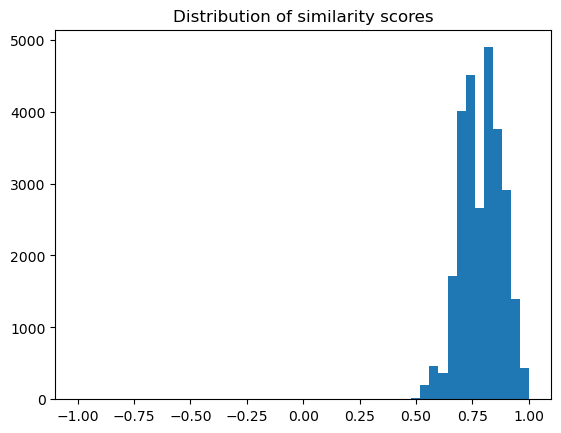

In [453]:
import matplotlib.pyplot as plt
plt.hist(similarity_scores, bins=50)
plt.title("Distribution of similarity scores")
plt.show()


In [454]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=32)
# item_embeddings = pca.fit_transform(X_item)

In [455]:
# item_embeddings

In [ ]:
def recommend_similar_games(game_ids, embeddings_normalized, games_data_clean, K=5):
    game_indices = []
    for game_id in game_ids:
        game_indices.append(
            item_features.index[item_features.gameId == game_id][0]
        )
        
    profile = embeddings_normalized[game_indices].mean(axis=0)
    print(profile)
    input()
    similarity_scores = embeddings_normalized.dot(profile)
    print(min(similarity_scores), max(similarity_scores))
    
    for ind in game_indices:
        similarity_scores[ind] = -1.0
    
    top_k = np.argsort(similarity_scores)[-K:][::-1]
    recommended_game_ids = item_features.iloc[top_k]['gameId']
    recommended_similarity_scores = similarity_scores[top_k]
    
    recommended_df = pd.DataFrame({
        'gameId': recommended_game_ids,
        'similarity_score': np.round(recommended_similarity_scores, 4)
    })
    
    return recommended_df.join(
        games_data_clean.set_index('gameId'), 
        on='gameId', 
        how='left'
    )[['gameId', 'title', 'genres','similarity_score']]

In [ ]:
game_indices = []
for game_id in game_ids[:5]:
    game_indices.append(
        item_features.index[item_features.gameId == game_id][0]
    )

AttributeError: 'DataFrame' object has no attribute 'movieId'

In [ ]:
game_indices

[]

In [ ]:
recommend_similar_games(list(game_ids[:6]), embeddings_normalized, games_data_clean, K=5)

AttributeError: 'DataFrame' object has no attribute 'movieId'

In [ ]:
gameIds = list(item_features[1:2].gameId)

AttributeError: 'DataFrame' object has no attribute 'movieId'

In [ ]:
game_names = games_data_clean[games_data_clean['gameId'].isin(gameIds)]['title']
# print(game_names.tolist())
game_genres = games_data_clean[games_data_clean['gameId'].isin(gameIds)]['genres']
# print(list(zip(game_names.tolist(), game_genres.tolist())))
for game_name, game_genres in zip(game_names.tolist(), game_genres.tolist()):
    print(game_name, ':\t\t', game_genres)

Mirror :		 Adventure|Indie|RPG
